In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
WDM_mass=[]
with open('WDM_TNG_MW_SB4.txt','r') as f:
    for i, line in enumerate(f.readlines()[1:]):
        WDM_mass.append([i,float(line.strip().split(' ')[0])])

WDM_mass = np.array(WDM_mass)

k = 60
# sorted_mass = WDM_mass[WDM_mass[:,1].argsort()]
# all_indices = sorted_mass[:k,0].astype(int).tolist()

all_indices = random.sample(range(1024),k)

config = {
        'img_size': 256,
        'dropout': 0.3,
        'batch_size': 32,
        'lr': 3e-4,
        'weight_decay': 1e-3,
        'epochs': 80,
        'patience': 15,
        'k_samples': 512,  # Number of samples to use
        'model_type': 'simple',  # 'simple' or 'big'
    }

In [3]:
class HDF5KeyImageDataset(Dataset):
    """Dataset class for loading CDM/WDM HDF5 files"""
    
    def __init__(self, cdm_path, wdm_path, transform=None):
        self.transform = transform
        self.data_sources = []  # List of (file_type, key_name, sub_index_if_needed)
        
        # Load CDM keys
        self.cdm_file = h5py.File(cdm_path)
        for key in self.cdm_file.keys():
            self.data_sources.append(('cdm', key, None))

        # Load WDM keys
        self.wdm_file = h5py.File(wdm_path)
        for key in self.wdm_file.keys():
            self.data_sources.append(('wdm', key, None))

    def __len__(self):
        return len(self.data_sources)

    def __getitem__(self, idx):
        source, key, sub_idx = self.data_sources[idx]
        h5_file = self.cdm_file if source == 'cdm' else self.wdm_file
        label = 0 if source == 'cdm' else 1
    
        arr = h5_file[key]
        img = arr[:] if sub_idx is None else arr[sub_idx]
    
        # Clean and normalize
        img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)
        img = np.clip(img, 0, None)  # Ensure non-negative
        img = img.astype(np.float32)
    
        if img.max() > 0:
            img = img / img.max()  # Normalize to [0, 1]
    
        # Convert to torch tensor and add channel dim
        img = torch.from_numpy(img).unsqueeze(0)  # shape: [1, H, W]
    
        if self.transform:
            img = self.transform(img)
    
        return img, torch.tensor(label, dtype=torch.float32)

    def __del__(self):
        if hasattr(self, 'cdm_file'):
            self.cdm_file.close()
        if hasattr(self, 'wdm_file'):
            self.wdm_file.close()

def load_multiple_hdf5_datasets(indices, transform=None, base_path='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images'):
    """Load multiple HDF5 datasets and concatenate them, skipping corrupted or missing files"""
    datasets = []
    for idx in indices:
        cdm_path = f'{base_path}/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        wdm_path = f'{base_path}/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        
        if not (os.path.exists(cdm_path) and os.path.exists(wdm_path)):
            print(f"Warning: Skipping missing files for box_{idx}")
            continue
        
        try:
            # Attempt to open files to detect corruption
            with h5py.File(cdm_path, 'r') as f:
                _ = list(f.keys())
            with h5py.File(wdm_path, 'r') as f:
                _ = list(f.keys())
        except Exception as e:
            print(f"Warning: Skipping corrupted file for box_{idx}: {e}")
            continue

        try:
            ds = HDF5KeyImageDataset(cdm_path, wdm_path, transform=transform)
            datasets.append(ds)
        except Exception as e:
            print(f"Warning: Skipping box_{idx} due to dataset init failure: {e}")
    
    if not datasets:
        raise ValueError("No valid datasets found!")
    
    return ConcatDataset(datasets)

In [4]:
class ConvBlock(nn.Module):
    """Convolutional block with BatchNorm and ReLU"""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
    
    def forward(self, x):
        return self.dropout(self.relu(self.bn(self.conv(x))))


class ResidualBlock(nn.Module):
    """Residual block for deeper CNNs"""
    
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        
        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        out += identity
        out = self.relu(out)
        return out


class SimpleCNN(nn.Module):
    """Simple CNN for binary classification"""
    
    def __init__(self, in_channels=1, num_classes=1, dropout=0.2):
        super().__init__()
        
        self.features = nn.Sequential(
            # First block
            ConvBlock(in_channels, 32, dropout=dropout),
            ConvBlock(32, 32, dropout=dropout),
            nn.MaxPool2d(2, 2),  # 256x256 -> 128x128
            
            # Second block
            ConvBlock(32, 64, dropout=dropout),
            ConvBlock(64, 64, dropout=dropout),
            nn.MaxPool2d(2, 2),  # 128x128 -> 64x64
            
            # Third block
            ConvBlock(64, 128, dropout=dropout),
            ConvBlock(128, 128, dropout=dropout),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32
            
            # Fourth block
            ConvBlock(128, 256, dropout=dropout),
            ConvBlock(256, 256, dropout=dropout),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
        )
        
        # Global average pooling + classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 16x16 -> 1x1
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
class SimpleResize(nn.Module):
    """Simple resize transform for validation/test sets (no augmentation)"""
    
    def __init__(self, size=(256, 256), apply_log=True):
        super().__init__()
        self.size = size
        self.apply_log = apply_log

    def forward(self, img):
        if img.dim() == 2:
            img = img.unsqueeze(0)
        elif img.dim() == 3 and img.shape[0] != 1:
            img = img[:1]

        img = F.interpolate(img.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False)
        if self.apply_log:
            img = torch.clamp(img, min=0)
            img = torch.log1p(img)
        return img.squeeze(0)

val_test_transform = SimpleResize(
        size=(config['img_size'], config['img_size']),
        apply_log=True  # Keep log scale
    )

In [9]:
# --- Setup ---
indices = list(random.sample(range(1024),50))  # Or whatever range you have
accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model
model = SimpleCNN().to(device)
checkpoint = torch.load('best_cnn_model_1.pt', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# --- Evaluation Loop ---
for idx in indices:
    cdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
    wdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'

    # Skip if either file doesn't exist
    if not (os.path.exists(cdm_path) and os.path.exists(wdm_path)):
        print(f"Skipping missing files: {cdm_path}, {wdm_path}")
        continue

    # Dataset and loader
    test_dataset = HDF5KeyImageDataset(cdm_path, wdm_path, transform=val_test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total if total > 0 else 0
    accuracies.append([int(idx), accuracy])
    print(f"Test Accuracy @ idx={idx}: {accuracy:.4f}")


Test Accuracy @ idx=874: 0.6851
Test Accuracy @ idx=74: 0.5058
Test Accuracy @ idx=786: 0.5408
Test Accuracy @ idx=394: 0.7012
Test Accuracy @ idx=714: 0.9213
Test Accuracy @ idx=619: 0.4927
Test Accuracy @ idx=422: 0.9402
Test Accuracy @ idx=341: 0.2507
Test Accuracy @ idx=944: 0.6181
Test Accuracy @ idx=626: 0.3746
Test Accuracy @ idx=828: 0.8484
Test Accuracy @ idx=102: 0.7595
Skipping missing files: /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_987/CDM/Galaxy_987.hdf5, /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_987/CDM/Galaxy_987.hdf5
Test Accuracy @ idx=821: 0.5175
Test Accuracy @ idx=415: 0.4271
Test Accuracy @ idx=509: 0.5000
Test Accuracy @ idx=713: 0.4781
Skipping missing files: /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_900/CDM/Galaxy_900.hdf5, /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_900/CDM/Galaxy_900.hdf5
Test Accuracy @ idx=191: 0.2216
Test Accuracy @ idx

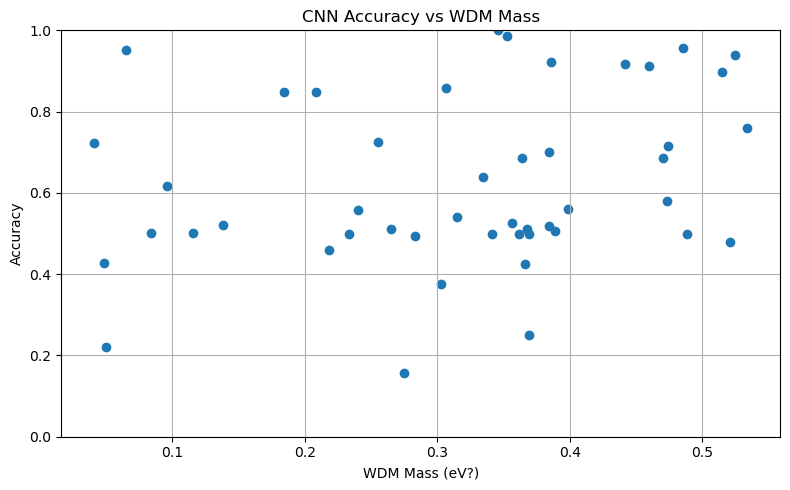

In [12]:
import matplotlib.pyplot as plt
# Step 1: Convert to dictionaries for fast lookup
a_to_b = dict(WDM_mass)
c_to_d = dict(accuracies)

# Step 2: Find common keys and construct [b, d] pairs
common_keys = set(a_to_b.keys()) & set(c_to_d.keys())
mass_accuracy = np.array([[a_to_b[k], c_to_d[k]] for k in common_keys])

plt.figure(figsize=(8, 5))
plt.scatter(mass_accuracy[:,0], mass_accuracy[:,1], marker='o')
plt.xlabel('WDM Mass (eV?)')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('CNN Accuracy vs WDM Mass')
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_vs_mass.png', dpi=300)
plt.show()
